In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# Exploratory Data Analysis

## Preprocessing

In [3]:
pd.read_csv("./combined_data_1.txt")

,,1:
1488844,3.0,2005-09-06
822109,5.0,2005-05-13
885013,4.0,2005-10-19
30878,4.0,2005-12-26
823519,3.0,2004-05-03
...,...,...
2591364,2.0,2005-02-16
1791000,2.0,2005-02-10
512536,5.0,2005-07-27
988963,3.0,2005-12-20


In [4]:
start=datetime.now()
if not os.path.isfile('data.csv'):
    # merge all 4 dataset into one in a particular format
    data=open("data.csv","w")
    row=list()
    files=["./combined_data_1.txt","./combined_data_2.txt","./combined_data_3.txt","./combined_data_4.txt"]
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f:
                line=line.strip()
                if line.endswith(':'):
                    movie_id=line.replace(':',"")
                else:
                    row=[x for x in line.split(',')]
                    row.insert(0,movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print('done.\n')
    data.close()
print("Time taken:",datetime.now()-start)

Reading ratings from ./combined_data_1.txt...
done.

Reading ratings from ./combined_data_2.txt...
done.

Reading ratings from ./combined_data_3.txt...
done.

Reading ratings from ./combined_data_4.txt...
done.



NameError: name 'datatime' is not defined

In [5]:
df=pd.read_csv('data.csv',sep=',',names=['movie','user','rating','date'])
df.date=pd.to_datetime(df.date)
df.sort_values(by='date',inplace=True)


In [6]:
df.to_csv('data.csv')

In [7]:
df=pd.read_csv("./data.csv")

In [7]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [8]:
df['rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [9]:
df.movie.value_counts()

5317     232944
15124    216596
14313    200832
15205    196397
1905     193941
          ...  
4806         13
11344        10
6256         10
11148         5
13755         3
Name: movie, Length: 17770, dtype: int64

In [10]:
df.user.value_counts()

305344     17653
387418     17436
2439493    16565
1664010    15813
2118461    14831
           ...  
1540076        1
1435719        1
1783877        1
1083938        1
1598417        1
Name: user, Length: 480189, dtype: int64

## Checking for null value

In [11]:
print("No of null values: ",sum(df.isnull().any()))

No of null values:  0


## Removing duplicate

In [12]:
dup=df.duplicated(['movie','user','rating'])
print(sum(dup))

0


## Basic Stats

In [3]:
print("Total Data")
print('-'*50)
print("Total ratings: ",df.rating.shape[0])
print("Total unique movies: ",len(np.unique(df.movie)))
print("Total unique users: ",len(np.unique(df.user)))

Total Data
--------------------------------------------------
Total ratings:  100480507
Total unique movies:  17770
Total unique users:  480189


## Splitting the data

In [6]:
if not os.path.isfile("train.csv"):
    df.iloc[:int(df.shape[0]*.80)].to_csv("train.csv",index=False)
if not os.path.isfile("test.csv"):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv",index=False)
train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

## EDA on train data

### distribution of rating

In [5]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [19]:
train_df.rating.value_counts()

4    27161596
3    23339084
5    17772845
2     8369795
1     3741085
Name: rating, dtype: int64

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_16336\2073058469.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


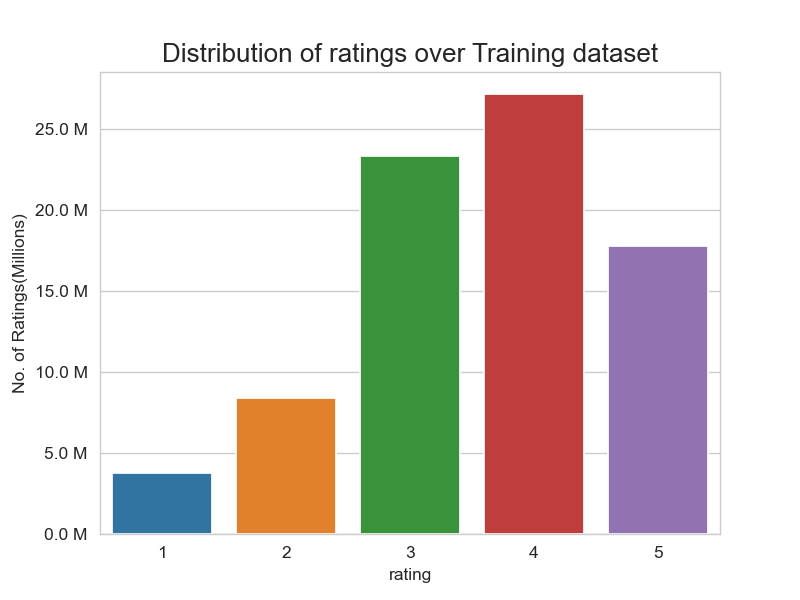

In [21]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(data=train_df,x='rating')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

add new column of week day for analysis

In [26]:
train_df['week_day']=train_df.date.dt.day_name()
train_df.head()

,Unnamed: 0,movie,user,rating,date,week_day
0,56431994,10341,510180,4,1999-11-11,Thursday
1,9056171,1798,510180,5,1999-11-11,Thursday
2,58698779,10774,510180,3,1999-11-11,Thursday
3,48101611,8651,510180,2,1999-11-11,Thursday
4,81893208,14660,510180,2,1999-11-11,Thursday


In [2]:
test_df = pd.read_csv("test.csv")

### ratings per month

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_16336\3396832395.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


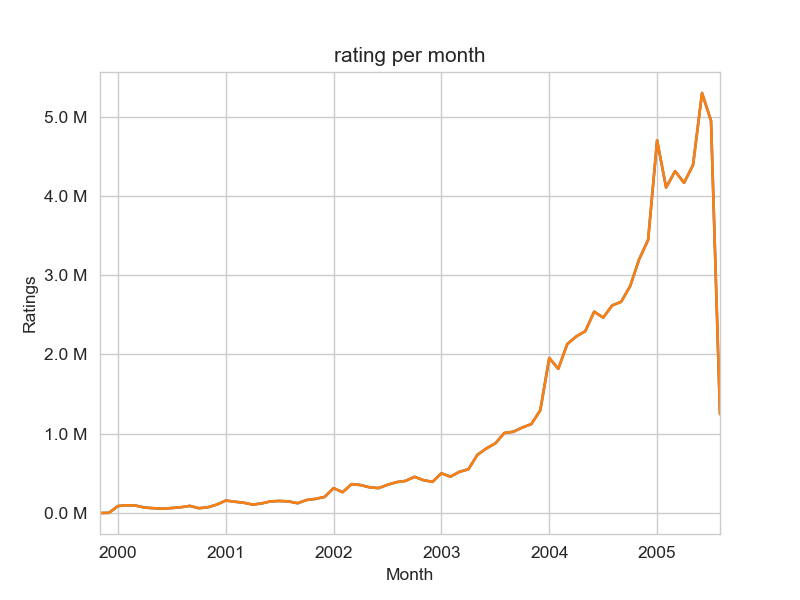

In [28]:
ax=train_df.resample('m',on='date')['rating'].count().plot()
ax.set_title("rating per month")
plt.xlabel("Month")
plt.ylabel("Ratings")
ax.set_yticklabels([human(item,'M') for item in ax.get_yticks()])
plt.show();

In [2]:
train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

In [3]:
train_df['week_day']=train_df.date.dt.day_name()

<h3>  Analysis on the Ratings given by user </h3>

In [4]:
no_of_ratings_givenby_user=train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_ratings_givenby_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_14304\1430251410.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_of_ratings_givenby_user,shade=True,ax=ax1)
C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_14304\1430251410.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_of_ratings_givenby_user,shade=True,ax=ax2,cumulative=True)


<IPython.core.display.Javascript object>


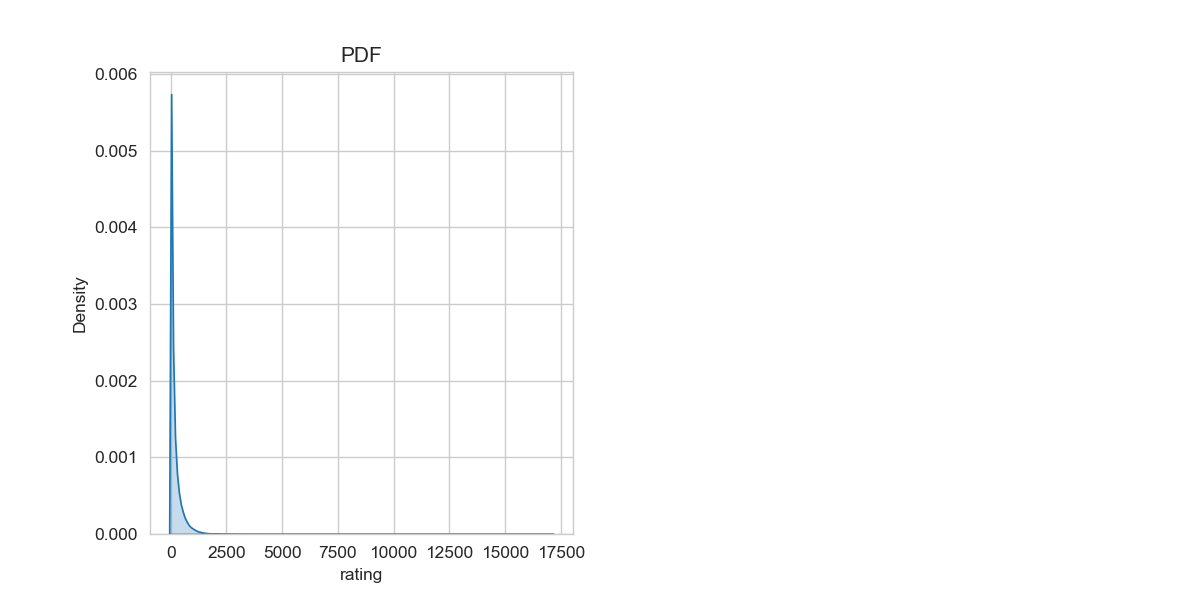

<IPython.core.display.Javascript object>


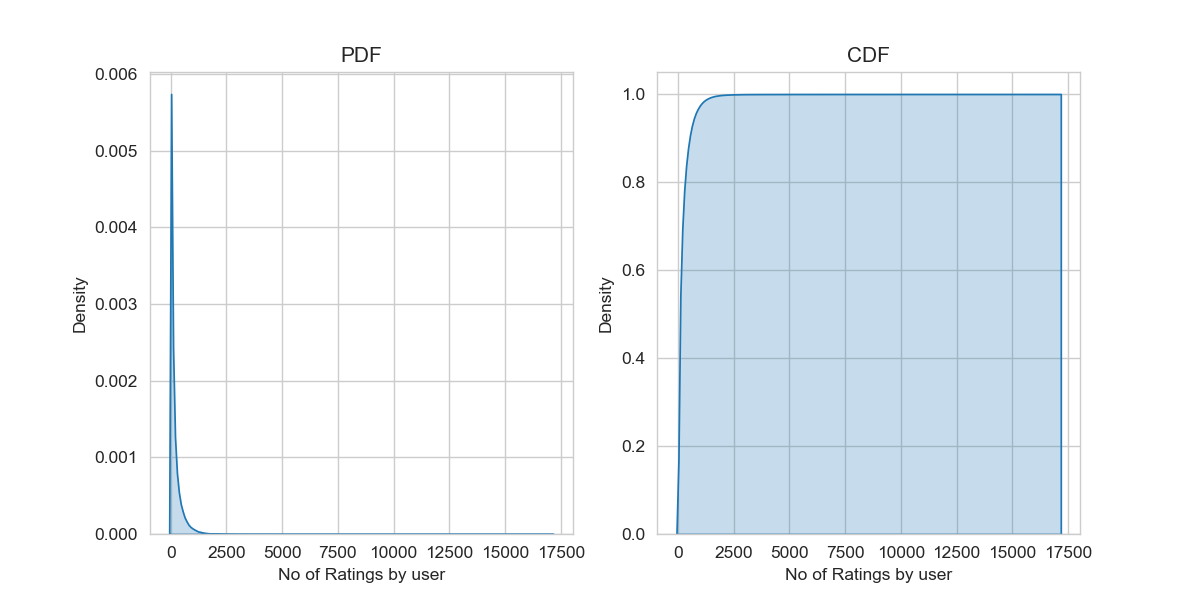

In [6]:
fig=plt.figure(figsize=plt.figaspect(.5))
ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_givenby_user,shade=True,ax=ax1)
plt.title("PDF")
plt.xlabel("No of Ratings by user")

ax2=plt.subplot(122)
sns.kdeplot(no_of_ratings_givenby_user,shade=True,ax=ax2,cumulative=True)
plt.title("CDF")
plt.xlabel("No of Ratings by user")

plt.show();

In [7]:
no_of_ratings_givenby_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [9]:
quantiles = no_of_ratings_givenby_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


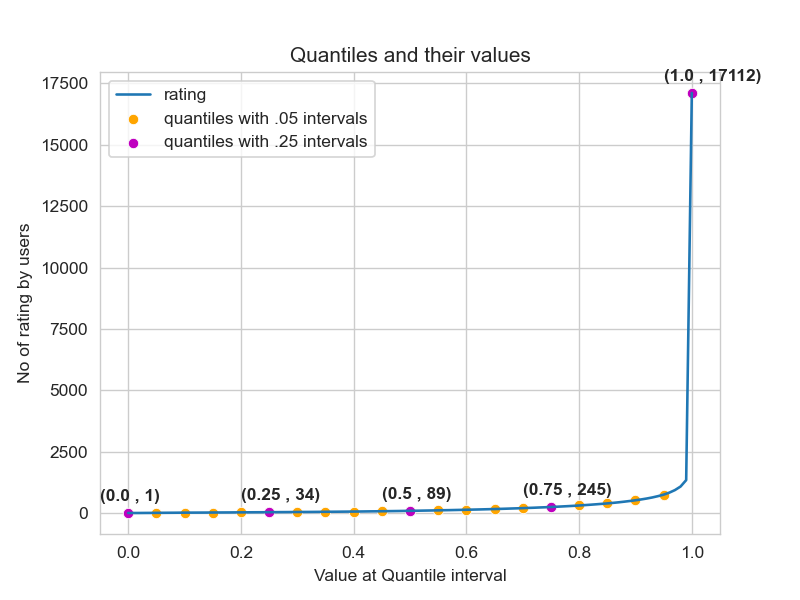

In [18]:
plt.title("Quantiles and their values")
quantiles.plot()
sns.scatterplot(x=quantiles.index[::5],y=quantiles.values[::5],c='orange',label="quantiles with .05 intervals")
sns.scatterplot(x=quantiles.index[::25],y=quantiles.values[::25],c='m',label="quantiles with .25 intervals")
plt.xlabel("Value at Quantile interval")
plt.ylabel("No of rating by users")
plt.legend(loc='best')
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')
plt.show();

In [19]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

In [24]:
print("No of users in top 5%: ", sum(no_of_ratings_givenby_user>=749))

No of users in top 5%:  20305


## Analysis of ratings of movies given by users

<IPython.core.display.Javascript object>


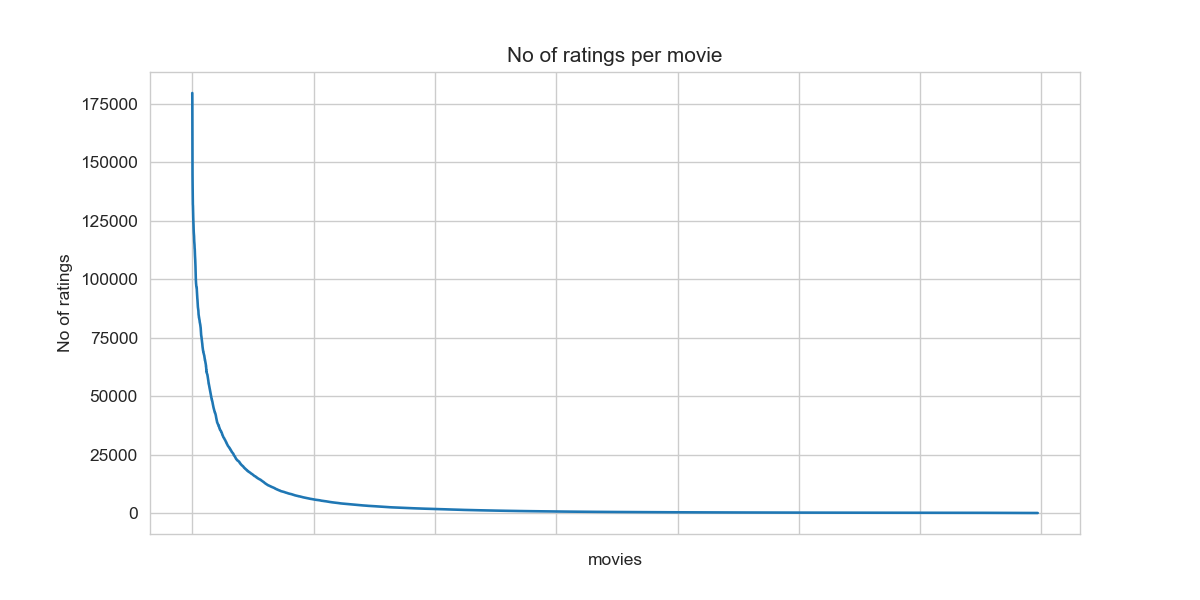

In [27]:
movies_ratings=train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)
plt.figure(figsize=plt.figaspect(0.5))
ax = plt.gca()
plt.plot(movies_ratings.values)
plt.title('No of ratings per movie')
plt.xlabel('movies')
ax.set_xticklabels([])

plt.ylabel("No of ratings")
plt.show();

### No of ratings per day of week

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_17648\1623574622.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])


<IPython.core.display.Javascript object>


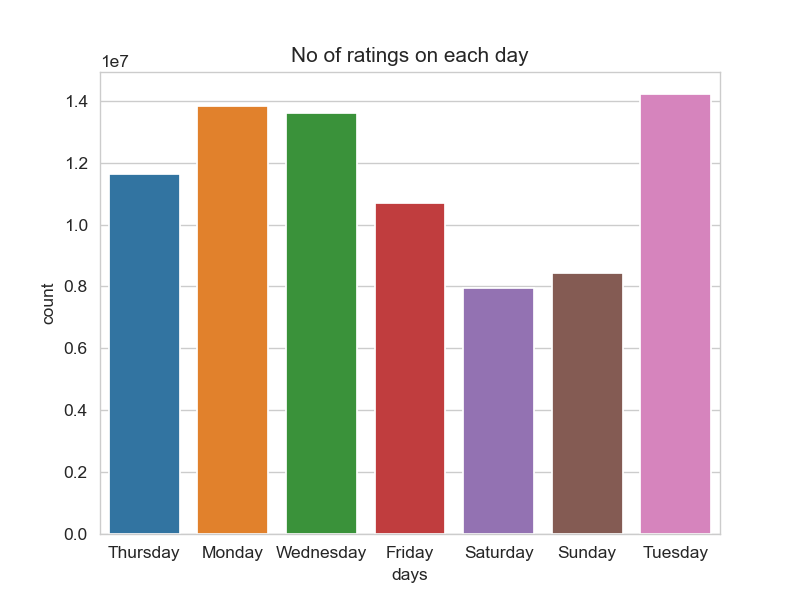

<IPython.core.display.Javascript object>


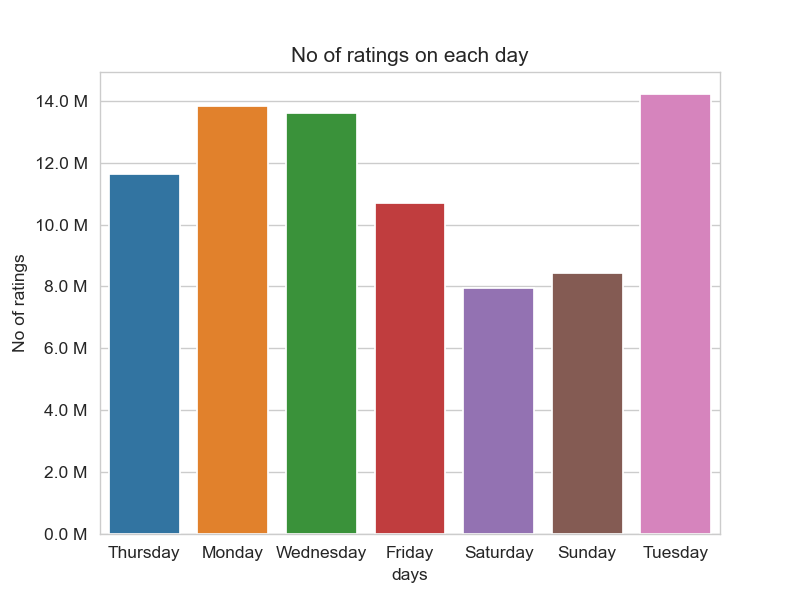

In [7]:
fig,ax=plt.subplots()
sns.countplot(x='week_day' ,data=train_df,ax=ax)
plt.title('No of ratings on each day')
plt.xlabel('days')
plt.ylabel('No of ratings')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show();

<IPython.core.display.Javascript object>


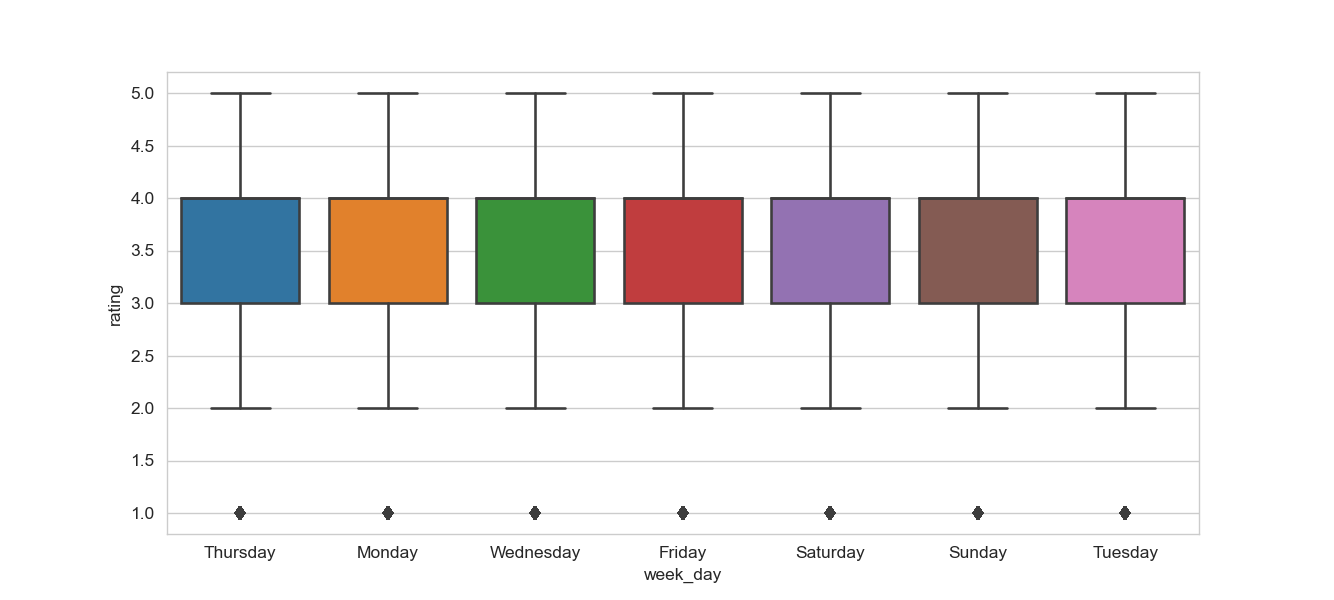

0:02:30.568448


In [10]:
start=datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating',x='week_day',data=train_df)
plt.show()
print(datetime.now() - start)

In [11]:
avg_week_df = train_df.groupby(by=['week_day'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
week_day
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




# Creating sparse matrix from data frame

## create sparse matrix for train data

In [12]:
start =datetime.now()

if os.path.isfile('train_sparse_matrix.npz'):
    print('file already present, fetching it ....')
    train_sparse_matrix=sparse.load_npz('train_sparse_matrix.npz')
else:
    print('Creating sparse matrix')
    train_sparse_matrix=sparse.csr_matrix((train_df.rating.values,(train_df.user.values,train_df.movie.values)),)
    sparse.save_npz("train_sparse_matrix.npz",train_sparse_matrix)
print("time taken: ",datetime.now()-start)

Creating sparse matrix
time taken:  0:00:48.529108


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [19]:
us,mv=train_sparse_matrix.shape
elem=train_sparse_matrix.count_nonzero()
print("Sparsity of train matrix : {} % ".format((1-(elem/(us*mv)))*100))


Sparsity of train matrix : 99.8292709259195 % 


## create sparse matriix for test data

In [3]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print('File already present, fetching it ....')
    train_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
else:
    print('Creating sparse matrix')
    test_sparse_matrix=sparse.csr_matrix((test_df.rating.values,(test_df.user.values,test_df.movie.values)),)
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)

print("Time taken: ", datetime.now() - start)


Creating sparse matrix
Time taken:  0:00:11.402225


In [4]:
us,mv=test_sparse_matrix.shape
elem=test_sparse_matrix.count_nonzero()
print("Sparsity of train matrix : {} % ".format((1-(elem/(us*mv)))*100))

Sparsity of train matrix : 99.95731772988694 % 


<h3> Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>


In [2]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

<h4> finding global average of all movie ratings </h4>

In [3]:
train_sparse_matrix = sparse.load_npz("Data/train_sparse_matrix.npz")

In [4]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

<h4> finding average by a user</h4>

In [5]:
train_averages['user']=get_average_ratings(train_sparse_matrix,True)
print("Average rating given by user 10 is ",train_averages['user'][10])

Average rating given by user 10 is  3.3781094527363185


<h4>finding avg rting per movie</h4>

In [6]:
train_averages['movie']=get_average_ratings(train_sparse_matrix,False)
print("Average rating given to movie 10 is ",train_averages['movie'][10])

Average rating given to movie 10 is  3.1945701357466065


<h4>PDF and CDF of avg rating of users and movies</h4>

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_6056\677456245.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_ratings, ax=ax1, hist=False,
C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_6056\677456245.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(u

<IPython.core.display.Javascript object>


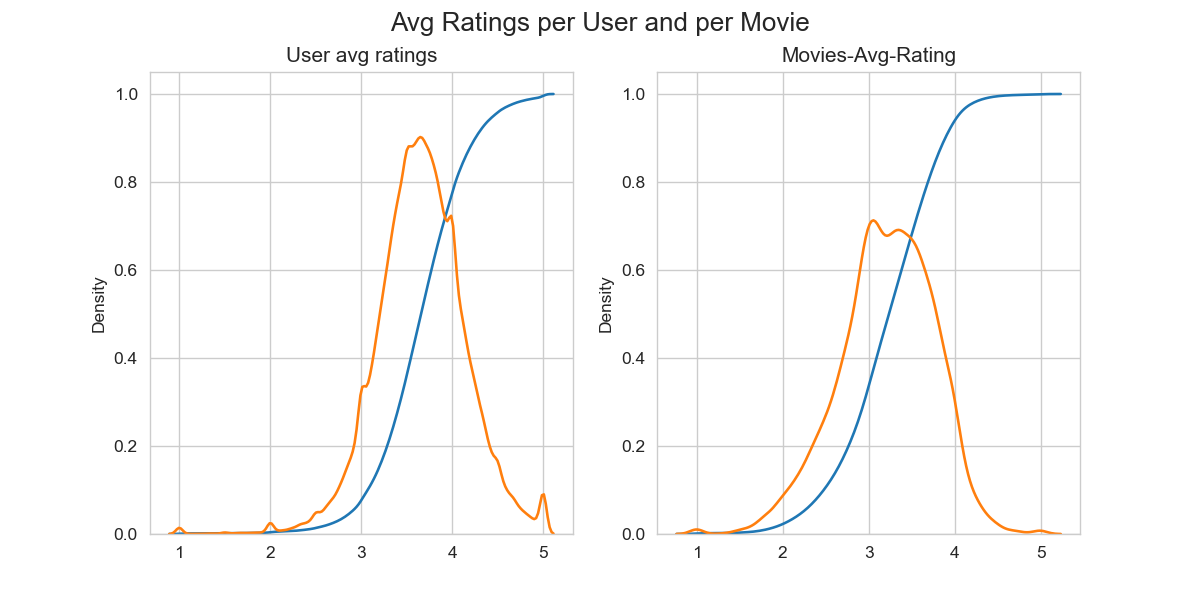

0:00:05.946473


In [18]:
start=datetime.now()

fig,(ax1,ax2)=plt.subplots(ncols=2,nrows=1,figsize=plt.figaspect(0.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('User avg ratings')
user_ratings=[rat for rat in train_averages['user'].values()]
sns.distplot(user_ratings, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_ratings, ax=ax1, hist=False,label='Pdf')
ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)
plt.show();

<h3>Cold start problem</h3>

<h4>cold start problem with users</h4>

In [10]:
total_users=len(np.unique(df.user))
train_users=len(train_averages['user'])
new_users=total_users-train_users
print("\n total no. of users: ",total_users)
print("\n users in train data: ",train_users)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


 total no. of users:  480189

 users in train data:  405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


<h4>cold start problem with movies</h4>

In [12]:
total_movies=len(np.unique(df.movie))
train_movies=len(train_averages['movie'])
new_movies=total_movies-train_movies
print("\n total movies: ",total_movies)
print("\n movies in train data: ",train_movies)
print("\n No of movies that didn't appear in train data: {}({} %) \n".format(new_movies,np.round((new_movies/total_movies)*100,2)))


 total movies:  17770

 movies in train data:  17424

 No of movies that didn't appear in train data: 346(1.95 %) 



## Computing similarity matrix

### computing similarity for user-user

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
def compute_user_similarity(sparse_matrix,top=30,verbose=False,ver_n_rows=5,compute_for_few=True,draw_time_taken=True):
    no_of_users,_=sparse_matrix.shape # get numbers of users present
    row_ind,col_ind=sparse_matrix.nonzero() # this will give me the row ,col of non empty cells 
    
    row_ind=sorted(set(row_ind)) # this will give me the sorted order of users which have rated at least one movie
    rows,cols,data=list(),list(),list()
    time_taken=list() # time taken to compute similarity for one user
    start = datetime.now()
    if verbose: print("Computing similarity for {} users...".format(top))
    temp=0
    for row in row_ind[:top]:
        temp=1+temp
        prev=datetime.now()
        
        sim=cosine_similarity(sparse_matrix.getrow(row),sparse_matrix).ravel()
        top_sim_ind=sim.argsort()[-top:]
        top_sim_val=sim[top_sim_ind]
        
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp()-prev.timestamp())
        if verbose:
            if temp%ver_n_rows==0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))

    if draw_time_taken:
        plt.plot(time_taken,label="time taken foe each user")
        plt.plot(np.cumsum(time_taken),label="total time")
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
    if verbose: print('Creating Sparse matrix from the computed similarities')
    
    return sparse.csr_matrix((data,(rows,cols)),shape=(no_of_users,no_of_users)),time_taken

Computing similarity for 30 users...
computing done for 5 users [  time elapsed : 0:00:14.618208  ]
computing done for 10 users [  time elapsed : 0:00:28.961241  ]
computing done for 15 users [  time elapsed : 0:00:43.784084  ]
computing done for 20 users [  time elapsed : 0:00:57.499845  ]
computing done for 25 users [  time elapsed : 0:01:12.882239  ]
computing done for 30 users [  time elapsed : 0:01:26.872732  ]


<IPython.core.display.Javascript object>


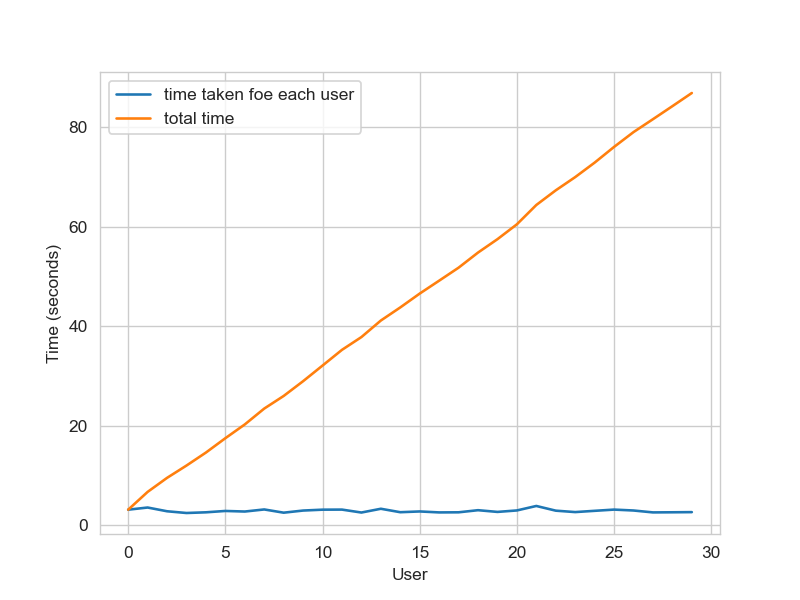

Creating Sparse matrix from the computed similarities
----------------------------------------------------------------------------------------------------
Time taken : 0:01:32.632881


In [17]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix,top = 30,verbose=True 
                                                     )
print("-"*100)
print("Time taken :",datetime.now()-start)

<h4> Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)</h4>

* We have  **405,041 users** in out training set and computing similarities between them..( **17K dimensional vector..**) is time consuming..


- From above plot, It took roughly __8.88 sec__ for computing simlilar users for __one user__
    
    
- We have __405,041 users__ with us in training set.


- ${ 405041 \times 8.88 = 3596764.08  \sec } =  59946.068 \min = 999.101133333 \text{ hours}
= 41.629213889 \text{ days}...$

    - Even if we run on 4 cores parallelly (a typical system now a days), It will still take almost __10 and 1/2__ days.
    
 IDEA:  Instead, we will try to reduce the dimentsions using SVD, so that __it might__ speed up the process...

In [2]:
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
train_sparse_matrix = sparse.load_npz("train_sparse_matrix.npz")

In [ ]:
start=datetime.now()
Netflix_svd=TruncatedSVD(n_components=500,algorithm='randomized',random_state=15)
truncat_svd=Netflix_svd.fit_transform(train_sparse_matrix)
print(datetime.now()-start)

In [7]:
# Load the transformed matrix from the file
trunc_matrix = sparse.load_npz("trunc_sparse_matrix.npz")

In [8]:
trunc_matrix.shape

(2649430, 500)

Computing similarity for 30 users...
computing done for 5 users [  time elapsed : 0:02:24.594027  ]
computing done for 10 users [  time elapsed : 0:04:53.249716  ]
computing done for 15 users [  time elapsed : 0:07:21.385187  ]
computing done for 20 users [  time elapsed : 0:09:47.346794  ]
computing done for 25 users [  time elapsed : 0:12:12.512037  ]
computing done for 30 users [  time elapsed : 0:14:30.492995  ]


<IPython.core.display.Javascript object>


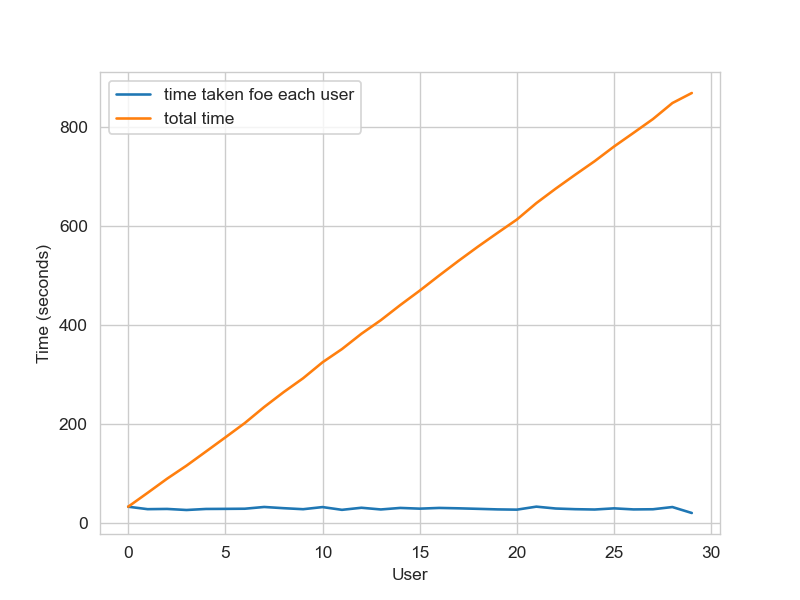

Creating Sparse matrix from the computed similarities
----------------------------------------------------------------------------------------------------
Time taken : 0:15:15.050647


In [14]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(trunc_matrix,top = 30,verbose=True 
                                                     )
print("-"*100)
print("Time taken :",datetime.now()-start)

<h3> Computing Movie-Movie Similarity matrix </h3>

In [37]:
train_sparse_matrix = sparse.load_npz("Data/train_sparse_matrix.npz")

In [17]:
if not os.path.isfile("m_m_sim_sparse"):
    m_m_sim_sparse=cosine_similarity(X=train_sparse_matrix.T,dense_output=False)
    sparse.save_npz("m_m_sim_sparse.npz",m_m_sim_sparse)

In [3]:
m_m_sim_sparse=sparse.load_npz('m_m_sim_sparse.npz')

In [10]:
np.unique(m_m_sim_sparse[:3].nonzero()[1]).shape

(17301,)

In [11]:
import numpy as np
from scipy.sparse import csr_matrix


num_movies = 17771


# Parameters for batch processing
batch_size = 500
num_batches = (num_movies + batch_size - 1) // batch_size

# Apply batch processing
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, num_movies)
    
    # Process the current batch
    batch_nonzero_indices = m_m_sim_sparse[start_idx:end_idx].nonzero()[1]
    
    # Apply np.unique() within the batch to reduce size
    unique_batch_movie_ids = np.unique(batch_nonzero_indices)
    
    # Save the unique batch to disk (you can replace 'batch_filename' with your desired filename pattern)
    batch_filename = f'batch_{batch_idx}.npy'
    np.save(batch_filename, unique_batch_movie_ids)
    
    # Clear memory by deleting the batch data
    del batch_nonzero_indices
    del unique_batch_movie_ids


KeyboardInterrupt: 

In [13]:
num_movies = 17771

# Parameters for batch processing
batch_size = 500
num_batches = (num_movies + batch_size - 1) // batch_size

# Initialize a list to accumulate unique movie IDs
all_unique_movie_ids = []

# Apply batch processing
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, num_movies)
    
    print("applying for batch {} to {} ...".format(start_idx,end_idx))
    
    # Process the current batch
    batch_nonzero_indices = m_m_sim_sparse[start_idx:end_idx].nonzero()[1]
    
    # Apply np.unique() within the batch to reduce size
    unique_batch_movie_ids = np.unique(batch_nonzero_indices)
    
   
    # Concatenate the unique IDs from the current batch to the accumulator array
    all_unique_movie_ids = np.concatenate((all_unique_movie_ids, unique_batch_movie_ids))
    all_unique_movie_ids = np.unique(all_unique_movie_ids)
    # Clear memory by deleting the batch data
    del batch_nonzero_indices
    del unique_batch_movie_ids

# Convert the list of all unique movie IDs to a NumPy array
all_unique_movie_ids = np.unique(all_unique_movie_ids)

# Save the array containing all unique movie IDs to a single file
np.save('all_unique_movie_ids.npy', all_unique_movie_ids)

applying for batch 0 to 500 ...
applying for batch 500 to 1000 ...
applying for batch 1000 to 1500 ...
applying for batch 1500 to 2000 ...
applying for batch 2000 to 2500 ...
applying for batch 2500 to 3000 ...
applying for batch 3000 to 3500 ...
applying for batch 3500 to 4000 ...
applying for batch 4000 to 4500 ...
applying for batch 4500 to 5000 ...
applying for batch 5000 to 5500 ...
applying for batch 5500 to 6000 ...
applying for batch 6000 to 6500 ...
applying for batch 6500 to 7000 ...
applying for batch 7000 to 7500 ...
applying for batch 7500 to 8000 ...
applying for batch 8000 to 8500 ...
applying for batch 8500 to 9000 ...
applying for batch 9000 to 9500 ...
applying for batch 9500 to 10000 ...
applying for batch 10000 to 10500 ...
applying for batch 10500 to 11000 ...
applying for batch 11000 to 11500 ...
applying for batch 11500 to 12000 ...
applying for batch 12000 to 12500 ...
applying for batch 12500 to 13000 ...
applying for batch 13000 to 13500 ...
applying for batch

In [40]:
similar_mov=dict()
for movie in movie_id:
    movie_index = int(movie)
    sim_mov=m_m_sim_sparse[movie_index].toarray().ravel().argsort()[::-1][1:]
    similar_mov[movie]=sim_mov[:100]
    
# Save the dictionary to a file
import pickle

with open('similar_movies.pkl', 'wb') as f:
    pickle.dump(similar_mov, f)

print("Similar movies dictionary saved.")    
    

Similar movies dictionary saved.


In [44]:
similar_mov[12155]

array([14410,  2372,  3938,  1905, 14240, 11521,  2452,  6037,  5496,
         191, 15107,  6134,  8387,  3962,  3860,  3624, 14691,  5401,
       15887, 15205,  4432, 12338,  3925, 14454, 10947,  1962,  8644,
       14621, 11089, 17355, 10042, 13081, 13728,  4306,   457, 11283,
        2874,  1220, 10583,  6206, 12785, 15124,  2782, 16954, 12161,
        6931, 11443, 12918, 14550, 11781, 11182, 10168,  5582,  6042,
        2862,  4043, 12582,  6971, 11314,   758,  9471, 16882, 17627,
       12732,  9960, 17088,  9628, 15471, 14312, 14644,  4972,  7624,
       17157,  4356,  5085, 16265,  6196,  2391, 16082,  8687,  3427,
         607, 17560,    30, 10820, 14670, 10550, 15788, 10730, 11337,
        7635,  1180,  2112,  5054,  8904, 16377, 15755, 10358, 13359,
        3333], dtype=int64)

In [15]:
movie_id=np.load('all_unique_movie_ids.npy')


In [30]:
import pandas as pd

# Preprocess the CSV file to change the first two commas to '|'
with open("Data/movie_titles.csv", "r") as file:
    csv_data = file.read()
    preprocessed_data = '\n'.join([line.replace(',', '|', 2) for line in csv_data.splitlines()])

# Save the preprocessed data to a temporary file
with open("Data/movie_titles_preprocessed.csv", "w") as file:
    file.write(preprocessed_data)

# Read the preprocessed CSV file using pandas
movie_titles = pd.read_csv("Data/movie_titles_preprocessed.csv", sep='|', header=None,
                          names=['movie_id', 'year_of_release', 'title'], verbose=True,
                          index_col='movie_id', encoding="ISO-8859-1")


movie_titles.head()


Tokenization took: 2.99 ms
Type conversion took: 4.99 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [35]:
movie_titles[movie_titles["title"]=='Spider-Man 2']


,year_of_release,title
movie_id,,
12155,2004.0,Spider-Man 2


<p style='font-size:15px'><b>Similar Movies for 'Spider-Man 2'</b></p>

In [43]:
mv_id=12155

print('\n movie name --->',movie_titles.loc[mv_id].values[1])
print("\n no. of ratings ---->",train_sparse_matrix[:mv_id].getnnz())
print("\n total movies available are ",m_m_sim_sparse[:,mv_id].getnnz())


 movie name ---> Spider-Man 2

 no. of ratings ----> 365364

 total movies available are  17408


In [49]:
m_m_sim_sparse.shape

(17771, 17771)

In [46]:
movie_titles.loc[similar_mov[12155][:10]]

,year_of_release,title
movie_id,,
14410,2002.0,Spider-Man
2372,2004.0,The Bourne Supremacy
3938,2004.0,Shrek 2
1905,2003.0,Pirates of the Caribbean: The Curse of the Bla...
14240,2003.0,Lord of the Rings: The Return of the King
11521,2002.0,Lord of the Rings: The Two Towers
2452,2001.0,Lord of the Rings: The Fellowship of the Ring
6037,2002.0,The Bourne Identity
5496,2004.0,"I, Robot"


In [50]:
similarities=m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices=similarities.argsort()[::-1][1:]

<IPython.core.display.Javascript object>


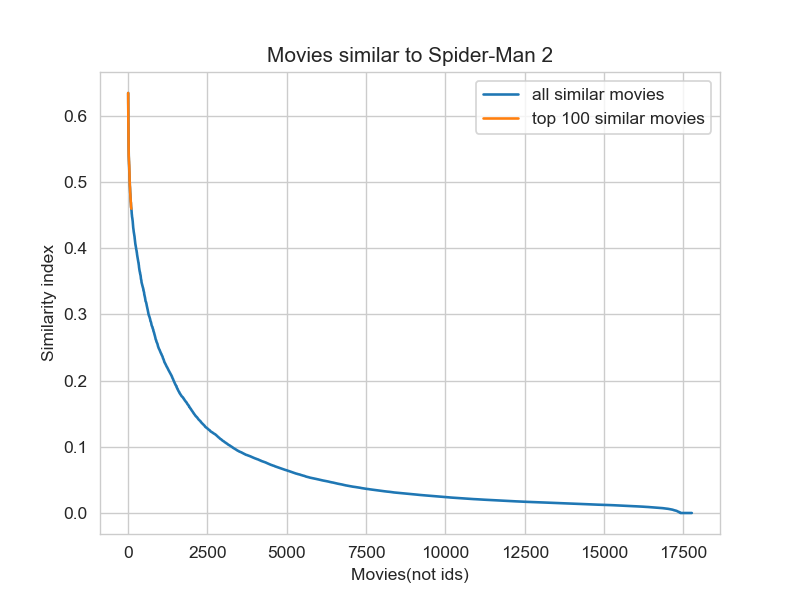

In [52]:
plt.plot(similarities[similar_indices],label="all similar movies")
plt.plot(similarities[similar_indices[:100]],label="top 100 similar movies")
plt.xlabel("Movies(not ids)")
plt.ylabel("Similarity index")
plt.title("Movies similar to Spider-Man 2")
plt.legend()
plt.show()

# Machine Learning models

In [3]:
import surprise

In [7]:
train_sparse_matrix=sparse.load_npz("Data/train_sparse_matrix.npz")

In [8]:
train_sparse_matrix.shape

(2649430, 17771)

In [12]:
def get_sample_sparse_matrix(sparse_matrix,no_users,no_movies):
    start=datetime.now()
    row_ind,col_ind,ratings=sparse.find(sparse_matrix)
    print(datetime.now()-start)
    # Save the arrays to separate files
    np.save("row_ind.npy", row_ind)
    np.save("col_ind.npy", col_ind)
    np.save("ratings.npy", ratings)


In [13]:
get_sample_sparse_matrix(train_sparse_matrix,100,50)

0:00:48.449089


In [17]:
ratings=np.load("ratings.npy")

In [18]:
ratings.shape

(80384405,)

In [19]:
def get_sample_sparse_matrix(sparse_matrix,no_users,no_movies):
    start=datetime.now()
    
    row_ind=np.load("row_ind.npy")
    col_ind=np.load("col_ind.npy")
    ratings=np.load("ratings.npy")
    
    users=np.unique(row_ind)
    movies=np.unique(col_ind)
    
    np.random.seed(15)
    sample_users=np.random.choice(users,no_users,replace=False)
    sample_movies=np.random.choice(movies,no_movies,replace=False)
    
    mask=np.logical_and(np.isin(row_ind,sample_users),np.isin(col_ind,sample_movies))
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))
    
    sparse.save_npz("Data/sample_sparse_matrix.npz", sample_sparse_matrix)
    print(datetime.now()-start)

In [22]:
get_sample_sparse_matrix(train_sparse_matrix,10000,1000)

0:00:36.382307


In [21]:
get_sample_sparse_matrix(train_sparse_matrix,300,150)

0:00:29.160232


In [2]:
sample_test_sparse=sparse.load_npz("Data/sample_test_sparse_matrix.npz")

<h2> Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [77]:
sample_train_averages = dict()

In [78]:
sample_train_sparse=sparse.load_npz("Data/sample_train_sparse_matrix.npz")

<h3> Finding Global Average of all movie ratings</h3>

In [79]:
global_avg=sample_train_sparse.sum()/sample_train_sparse.count_nonzero()
sample_train_averages['global'] = global_avg
sample_train_averages

{'global': 3.581679377504138}

### Finding Average rating per User

In [80]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [81]:
sample_train_averages["User"]=get_average_ratings(sample_train_sparse,True)
print("Avg rating for user 1515220 is: ",sample_train_averages["User"][1515220])

Avg rating for user 1515220 is:  3.9655172413793105


### Finding Average rating per Movie

In [82]:
sample_train_averages["Movie"]=get_average_ratings(sample_train_sparse,False)
print("Avg rating for movie 15299 is: ",sample_train_averages["Movie"][15299])

Avg rating for movie 15299 is:  2.6666666666666665


In [83]:
sample_train_averages["Movie"]

{33: 4.092436974789916,
 40: 2.5,
 41: 5.0,
 57: 3.8840579710144927,
 70: 2.8,
 72: 3.1666666666666665,
 73: 4.0,
 74: 3.5,
 106: 4.333333333333333,
 107: 3.2083333333333335,
 135: 4.4,
 162: 4.0,
 178: 3.4186046511627906,
 180: 3.8214285714285716,
 185: 3.142857142857143,
 186: 3.6666666666666665,
 190: 1.6,
 236: 1.0,
 360: 2.5714285714285716,
 380: 3.8333333333333335,
 397: 4.454545454545454,
 402: 3.0,
 472: 3.3125,
 476: 3.972972972972973,
 483: 3.45385450597177,
 485: 3.5483870967741935,
 526: 2.3333333333333335,
 564: 3.188340807174888,
 582: 2.9393939393939394,
 587: 3.5,
 607: 3.533333333333333,
 609: 3.6363636363636362,
 648: 3.0,
 723: 2.946875,
 766: 2.8,
 782: 2.0,
 831: 3.1132075471698113,
 836: 3.4705882352941178,
 850: 3.547169811320755,
 877: 3.75,
 893: 4.0,
 899: 3.5,
 937: 3.798594847775176,
 945: 3.0,
 1011: 3.229299363057325,
 1028: 3.25,
 1052: 4.0,
 1080: 3.136986301369863,
 1087: 2.9767441860465116,
 1098: 3.99009900990099,
 1116: 3.074626865671642,
 1147: 4.0,

In [10]:
sample_train_sparse.shape

(2649405, 17724)

In [11]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 129286


 No of ratings in Our Sampled test  matrix is : 7333



In [12]:
print(sample_train_sparse[:1000][:])

  (692, 5317)	4
  (692, 14621)	4


# Featurizing data for regression

In [13]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse)

In [23]:
start=datetime.now()
if os.path.isfile("Data/reg1_train.csv"):
    print("Already have the data...")
else:
    with open("Data/reg_train.csv",mode="w") as reg_train_data:
        count=0
        for(user,movie,rating) in zip(sample_train_users,sample_train_movies,sample_train_ratings):
            st=datetime.now()
#             print(user,movie)
            #      ------------- ratings of movie by similar users to user-------------------------
            # compute user user similarity for "user"
            sim_user=cosine_similarity(sample_train_sparse[user],sample_train_sparse).ravel()
            top_sim_users=sim_user.argsort()[::-1][1:]
            top_ratings=sample_train_sparse[top_sim_users,movie].toarray().ravel()
            top_sim_user_ratings=list(top_ratings[top_ratings!=0][:5])
            top_sim_user_ratings.extend([sample_train_averages['Movie'][movie]]*(5-len(top_sim_user_ratings)))
            
            #      ------------- ratings of similar movies by user-------------------------
            # compute movie movie similarity
            sim_mov=cosine_similarity(sample_train_sparse[:,movie].T,sample_train_sparse.T).ravel()
            top_sim_movie=sim_mov.argsort()[::-1][1:]
            top_ratings=sample_train_sparse[user,top_sim_movie].toarray().ravel()
            top_sim_mov_rating=list(top_ratings[top_ratings!=0][:5])
            top_sim_mov_rating.extend([sample_train_averages['User'][user]]*(5-len(top_sim_mov_rating)))
            
            #-----------------prepare the row to be stores in a file-----------------#
            row=list()
            row.append(user)
            row.append(movie)
            # now add other features
            row.append(sample_train_averages['global'])
            # next 5 features are similar_users "movie" ratings
            row.append(top_sim_user_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_mov_rating)
            # Avg_user rating
            row.append(sample_train_averages['User'][user])
            # Avg_movie rating
            row.append(sample_train_averages['Movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1
            # add rows to the file opened..
            reg_train_data.write(','.join(map(str, row)))
            reg_train_data.write('\n')        
            if (count)%100 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

Done for 100 rows----- 0:00:23.329181
Done for 200 rows----- 0:00:44.150183
Done for 300 rows----- 0:01:04.294674
Done for 400 rows----- 0:01:22.923990
Done for 500 rows----- 0:01:41.547503
Done for 600 rows----- 0:02:02.677493
Done for 700 rows----- 0:02:22.002781
Done for 800 rows----- 0:02:43.526340
Done for 900 rows----- 0:03:05.590616
Done for 1000 rows----- 0:03:25.448966
0:03:25.448966


In [4]:
reg_train = pd.read_csv('Data/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


#### featurizing test data

In [24]:
# gettig user,movie and ratings from simple test sparse
sample_test_users,sample_test_movies,sample_test_ratings=sparse.find(sample_test_sparse)

In [29]:
start=datetime.now()

if os.path.isfile("Data/reg_test1.csv"):
    print("file already present...")
    
else:
    with open("Data/reg_test1.csv",mode="w") as reg_data_file:
        count=0
        for(user,movie,rating) in zip(sample_test_users,sample_test_movies,sample_test_ratings):
            st=datetime.now()
            try:
                #----------- rating given by similar users to movie-----------------
                # finding user user cosinne similarity
                sim_user=cosine_similarity(sample_test_sparse[user],sample_test_sparse).ravel()
                top_sim_user=sim_user.argsort()[::-1][1:]
                top_ratings=sample_test_sparse[top_sim_user,movie].toarray().ravel()
                top_sim_user_ratings=list(top_ratings[top_ratings!=0])
                top_sim_user_ratings.extend([sample_train_averages['Movie'][movie]]*(5 - len(top_sim_user_ratings)))
            except (IndexError,KeyError):
                top_sim_user_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_user_ratings)))
            except :
                print(user,movie)
                raise
                
            try:
                #----------- rating given to similar movie-----------------
                # finding movie movie cosinne similarity
                sim_mov=cosine_similarity(sample_test_sparse[:,movie].T,sample_test_sparse.T).ravel()
                top_sim_mov=sim_mov.argsort()[::-1][1:]
                top_ratings=sample_test_sparse[user,top_sim_mov].toarray().ravel()
                top_sim_mov_ratings=list(top_ratings[top_ratings!=0])
                top_sim_mov_ratings.extend([sample_train_averages['User'][user]]*(5-len(top_sim_mov_ratings)))

            except (IndexError,KeyError):
                top_sim_mov_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_mov_ratings)))
            except :
                print(user,movie)
                raise
                
                
            # prepare row to store the data---------------#
            row=list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_user_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_mov_ratings)
            # Avg_user rating
            try:
                row.append(sample_train_averages['User'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['Movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%200 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

 0:00:02.812348


In [5]:
reg_test = pd.read_csv('Data/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_test.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1


### transforming data for surprise library

In [2]:
from surprise import Reader,Dataset

#### transforming train data

In [6]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

#### transfoeming test data

In [7]:
testset = list(zip(reg_test.user.values, reg_test.movie.values, reg_test.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

### Applying machine learning models

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [8]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [18]:
def get_error_metrics(y_true,y_pred):
    rmse=np.sqrt(np.mean([(y_true[i]-y_pred[i])**2 for i in range(len(y_pred))]))
    mape=np.mean(np.abs(y_pred-y_true)/y_true)*100
    return rmse,mape
    
def run_xgboost(algo,x_train,y_train,x_test,y_test):
    
    train_results=dict()
    test_results=dict()
    
    # fit the model
    print("training the model--")
    st=datetime.now()
    algo.fit(x_train,y_train,eval_metric="rmse")
    print("Done time taken {}\n".format(datetime.now()-st))
    
    # get predictions
    y_train_pred=algo.predict(x_train)
    # get rmse and mape of train data
    rmse_train,mape_train=get_error_metrics(y_train.values,y_train_pred)
    
    # store the results
    train_results={
        'rmse':rmse_train,
        'mape':mape_train,
        'predictions':y_train_pred
    }
    
    ################################################################
    
    # get the pred for test
    print("predictiong test data...")
    y_test_pred=algo.predict(x_test)
    rmse_test,mape_test=get_error_metrics(y_test.values,y_test_pred)
    test_results={
        'rmse':rmse_test,
        'mape':mape_test,
        'predictions':y_test_pred
    }
    print('\nTEST DATA')
    print('-'*30)
    print('RMSE : ', rmse_test)
    print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

> __Utility function for surprise models__

In [15]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)


def get_ratings(predictions):
    actual=[pred.r_ui for pred in predictions]
    pred=[pred.est for pred in predictions]
    return actual,pred


def get_errors(predictions):
    actual, pred = get_ratings(predictions)
    actual= np.array(actual)
    pred= np.array(pred)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

   
    return rmse,mape*100


def run_surprise(algo,trainset,testset):
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algo with trainset
    st=datetime.now()
    print("training the model....")
    algo.fit(trainset)
    print("done,time taken : \n",datetime.now()-start)
        # ---------------- Evaluating train data--------------------#
    st=datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds=algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('-'*15)
    print('Train Data')
    print('-'*15)
    print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
        #------------ Evaluating Test data---------------#
    print('\nEvaluating for test data...')
    # get the train predictions (list of prediction class inside Surprise)
    test_preds=algo.test(testset)
    test_actual_ratings,test_pred_ratings= get_ratings(test_preds)
    test_rmse,test_mape=get_errors(test_preds)
    print('-'*15)
    print('Test Data')
    print('-'*15)
    print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    test['rmse']=test_rmse
    test['mape']=test_mape
    test['predictions']=test_pred_ratings
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h3> XGBoost with initial 13 features </h3>

In [20]:
import xgboost as xgb

In [11]:
!pip install xgboost


     ---------------------------------------- 70.9/70.9 MB 2.9 MB/s eta 0:00:00


training the model--


D:\ds_projects\project_1\env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done time taken 0:00:05.732869

predictiong test data...

TEST DATA
------------------------------
RMSE :  1.1578258728250526
MAPE :  32.038137171288945


<IPython.core.display.Javascript object>


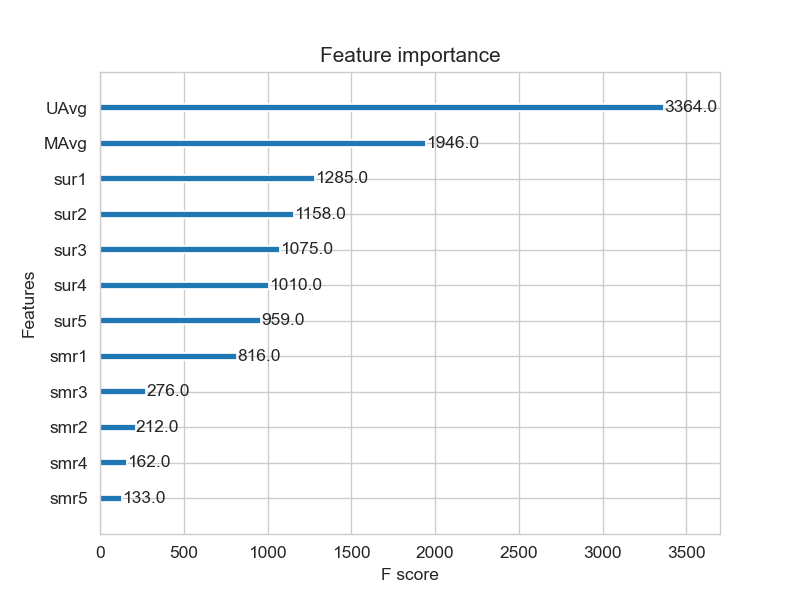

In [21]:
# prepare train data
x_train=reg_train.drop(["user","movie","rating"],axis=1)
y_train=reg_train['rating']

# prepare test data
x_test=reg_test.drop(["user","movie","rating"],axis=1)
y_test=reg_test['rating']

# initialize Our first XGBoost model...
first_xgb=xgb.XGBRegressor(n_jobs=13, random_state=15, n_estimators=200,learning_rate=0.01)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)


# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

In [21]:
models_evaluation_test

{'first_algo': {'rmse': 1.1578258728250526,
  'mape': 32.038137171288945,
  'predictions': array([3.1514072, 3.1514072, 3.1514072, ..., 3.1514072, 3.1514072,
         3.1514072], dtype=float32)}}

<h3> Suprise BaselineModel </h3>
    


In [11]:
from surprise import BaselineOnly 

In [16]:
# options are to specify.., how to compute those user and item biases
bsl_options={
    'method':'sgd',
    'learning_rate':.001
}
bsl_algo=BaselineOnly(bsl_options=bsl_options)
bsl_train_results,bsl_test_results=run_surprise(bsl_algo,trainset, testset)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

training the model....
Estimating biases using sgd...
done,time taken : 
 0:00:00.543015
Evaluating the model with train data..
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183


Evaluating for test data...
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911


---------------------------------------------
Total time taken to run this algorithm : 0:00:01.397258


<h3>XGBoost with initial 13 features + Surprise Baseline predictor </h>

__Updating Train Data__

In [22]:
# add our baseline_predicted value as our feature..
reg_train['bslpr']=models_evaluation_train['bsl_algo']['predictions']
reg_test['bslpr']=models_evaluation_test['bsl_algo']['predictions']
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637


training the model--


D:\ds_projects\project_1\env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done time taken 0:00:10.343174

predictiong test data...

TEST DATA
------------------------------
RMSE :  1.159050999376597
MAPE :  32.01655003985381


<IPython.core.display.Javascript object>


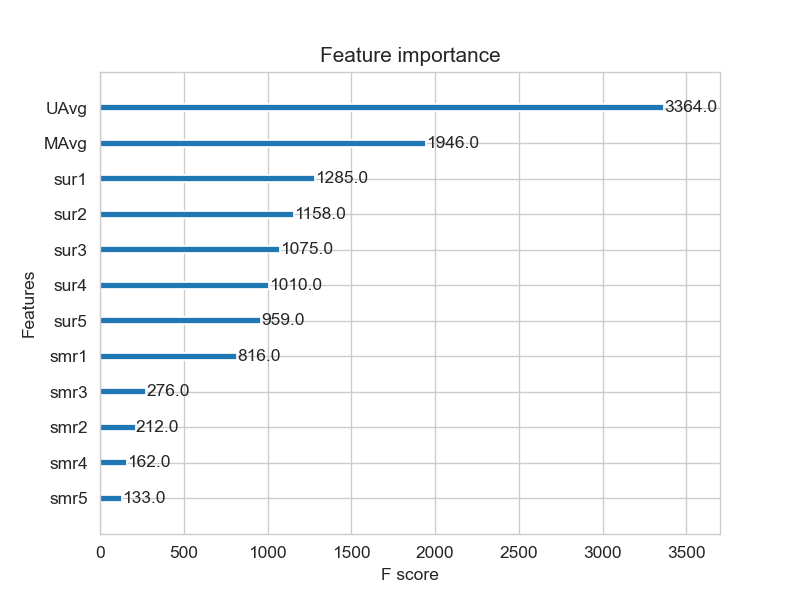

In [23]:
# prepare train data
x_train=reg_train.drop(["user","movie","rating"],axis=1)
y_train=reg_train['rating']

# prepare test data
x_test=reg_test.drop(["user","movie","rating"],axis=1)
y_test=reg_test['rating']

# initialize Our  XGBoost model...
xgb_bsl=xgb.XGBRegressor(n_jobs=13, random_state=15, n_estimators=200,learning_rate=0.01)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)


# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

# My approach

In [5]:
sample_sparse=sparse.load_npz("Data/train_sparse_matrix.npz")

In [6]:
sample_sparse.shape

(2649430, 17771)

In [7]:
sample_sparse.nnz

80384405

In [8]:
import numpy as np
from scipy.sparse import csr_matrix

# Assuming you have your sparse matrix 'original_matrix' in CSR format

# Step 1: Find top 1000 columns
col_nonzero_counts = sample_sparse.getnnz(axis=0)  # Count non-zero elements in each column
top_500_columns = np.argsort(col_nonzero_counts)[-500:]  # Indices of top 500 columns

# Step 2: Find top 5000 rows within selected columns
row_indices = []
for col_idx in top_500_columns:
    col_data = sample_sparse.getcol(col_idx).data
    top_rows_in_col = np.argsort(col_data)[-8000:]  # Indices of top 5000 rows in this column
    row_indices.extend(top_rows_in_col)

# Step 3: Create new sparse matrix
row_indices = np.unique(row_indices)  # Remove duplicate rows
selected_rows = sample_sparse[row_indices, :]
new_sparse_matrix1 = selected_rows[:, top_500_columns]

# Convert the new_sparse_matrix to CSR format if needed
new_sparse_matrix1 = csr_matrix(new_sparse_matrix1)

# Now, new_sparse_matrix contains the desired matrix with top 1000 columns and top 5000 rows.


In [35]:
print(new_sparse_matrix1.shape)
print(new_sparse_matrix1.nnz)

(120990, 500)
1666661


In [43]:
my_train_sparse=new_sparse_matrix1[:9000,]

In [44]:
my_train_sparse.nnz

121096

In [45]:
sparse.save_npz("Data/my_train_sparse.npz",my_train_sparse)

In [58]:
my_test_sparse=new_sparse_matrix1[9000:12000,]

In [59]:
my_test_sparse.nnz

42118

In [60]:
sparse.save_npz("Data/my_test_sparse.npz",my_test_sparse)

In [70]:
sample_train_users, sample_train_movies, sample_train_ratings=sparse.find(my_train_sparse[:200,])

In [89]:
np.unique(sample_train_users)

array([  6,   7,  10,  25,  33,  42,  59,  79,  83,  87,  94,  97, 131,
       134, 142, 149, 158, 168, 169, 178, 183, 188, 192, 195, 199])

In [85]:
start = datetime.now()
if os.path.isfile('Data/my_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('Data/my_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(my_train_sparse[user], my_train_sparse).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = my_train_sparse[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['Movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(my_train_sparse[:,movie].T, my_train_sparse.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = my_train_sparse[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['User'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['User'][user])
            # Avg_movie rating
            row.append(sample_train_averages['Movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 3091 tuples for the dataset..



KeyError: 0

In [ ]:
start=datetime.now()
if os.path.isfile("Data/reg1_train.csv"):
    print("Already have the data...")
else:
    with open("Data/reg_train.csv",mode="w") as reg_train_data:
        count=0
        for(user,movie,rating) in zip(sample_train_users,sample_train_movies,sample_train_ratings):
            st=datetime.now()
#             print(user,movie)
            #      ------------- ratings of movie by similar users to user-------------------------
            # compute user user similarity for "user"
            sim_user=cosine_similarity(sample_train_sparse[user],sample_train_sparse).ravel()
            top_sim_users=sim_user.argsort()[::-1][1:]
            top_ratings=sample_train_sparse[top_sim_users,movie].toarray().ravel()
            top_sim_user_ratings=list(top_ratings[top_ratings!=0][:5])
            top_sim_user_ratings.extend([sample_train_averages['Movie'][movie]]*(5-len(top_sim_user_ratings)))
            
            #      ------------- ratings of similar movies by user-------------------------
            # compute movie movie similarity
            sim_mov=cosine_similarity(sample_train_sparse[:,movie].T,sample_train_sparse.T).ravel()
            top_sim_movie=sim_mov.argsort()[::-1][1:]
            top_ratings=sample_train_sparse[user,top_sim_movie].toarray().ravel()
            top_sim_mov_rating=list(top_ratings[top_ratings!=0][:5])
            top_sim_mov_rating.extend([sample_train_averages['User'][user]]*(5-len(top_sim_mov_rating)))
            
            #-----------------prepare the row to be stores in a file-----------------#
            row=list()
            row.append(user)
            row.append(movie)
            # now add other features
            row.append(sample_train_averages['global'])
            # next 5 features are similar_users "movie" ratings
            row.append(top_sim_user_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_mov_rating)
            # Avg_user rating
            row.append(sample_train_averages['User'][user])
            # Avg_movie rating
            row.append(sample_train_averages['Movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1
            # add rows to the file opened..
            reg_train_data.write(','.join(map(str, row)))
            reg_train_data.write('\n')        
            if (count)%100 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)